In [99]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np

In [1]:
import pandas as pd
# make sure that test_df has the results of bert and lstm horizontally attached, because you need to average 
# accuracies for a particular word
df_memory = pd.read_pickle("test_df.pkl")

In [3]:
df_memory.to_csv('test_df.csv', sep = '\t')

In [4]:
len(df_memory)

35033

In [13]:
list(df_memory.columns)

['query',
 'context',
 'label',
 'context_length',
 'valence',
 'arousal',
 'dominance',
 'num_meanings',
 'num_rep',
 'int_tok',
 'tokenized_context_length',
 'bert_pred',
 'bert_pred_label',
 'bert_conf_of_correct_class',
 'success',
 'query_lemma',
 'query_pos',
 'count',
 'count_bin_id',
 'valence_id',
 'arousal_id',
 'dominance_id']

In [26]:
# create new columns for VAD, count, num_meanings normalized
df_memory["valence"] = pd.to_numeric(df_memory["valence"])
df_memory["arousal"] = pd.to_numeric(df_memory["arousal"])
df_memory["dominance"] = pd.to_numeric(df_memory["dominance"])

In [31]:
tags = df_memory['query_pos'].unique()

In [38]:
# convert query_pos which is a string into a categorical variable
df_memory['query_pos_categorical']= df_memory['query_pos'].replace(tags,
                        range(0, len(tags)))

In [76]:
query_success_rate = df_memory.groupby(["query"], group_keys=False).apply(lambda x: x['success'].mean())

In [95]:
query_success_rate['navy']

0.6111111111111112

In [82]:
df_memory_unique = df_memory.drop_duplicates('query', keep='first')

In [85]:
len(df_memory_unique)

1954

In [91]:
df_memory_unique['avg_accuracy'] = df_memory_unique.apply(lambda x: query_success_rate[x['query']], axis=1)

/opt/conda/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [92]:
df_memory_unique.head()

,query,context,label,context_length,valence,arousal,dominance,num_meanings,num_rep,int_tok,...,query_lemma,query_pos,count,count_bin_id,valence_id,arousal_id,dominance_id,valence_normalized,query_pos_categorical,avg_accuracy
0,belief,Vitellius began his reign with a large funeral...,1,47,0.896,0.375,0.656,2,1,18,...,belief,NN,12108114,0,8,3,6,1.703021,0,0.944444
1,first,In 2015 UPM was ranked 41st in the UI World Un...,0,98,0.625,0.500,0.788,16,0,-1,...,first,JJ,578161543,4,6,4,7,0.257049,1,0.785796
2,capacity,"Currently , 45 of Malaysian natural gas is fou...",1,132,0.719,0.411,0.806,9,1,61,...,capacity,NN,48726947,0,7,3,8,0.758604,0,0.892857
3,small,"However , the airstrip was heavily bombed by A...",1,409,0.542,0.205,0.120,13,1,209,...,small,JJ,208371878,1,5,1,0,-0.185813,1,0.909091
4,navy,Though the ships were laid down in 1873 their ...,1,44,0.531,0.760,0.764,3,1,23,...,navy,JJ,22018379,0,5,7,7,-0.244506,1,0.611111


In [365]:
#features = df_memory_unique[["valence","arousal","dominance", "num_meanings", "query_pos_categorical", "count"]].values
features = df_memory_unique[["query_pos_categorical"]].values

#features = df_memory_unique[["context_length", "int_tok", "num_rep"]].values
#features = df_memory_unique[["context_length"]].values
words = df_memory_unique['query'].values
target_accuracy = df_memory_unique['avg_accuracy'].values

In [347]:
features.shape[0]

1954

In [304]:
ids = target_accuracy<1.0
target_accuracy = target_accuracy[ids]
features = features[ids]
words = words[ids]

(array([ 48.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   3.,   0.,   1.,   1.,  28.,   0.,   1.,   0.,   7.,   4.,
          6.,   1.,   0., 120.,   1.,   6.,  11.,   4.,  28.,  23.,  12.,
        117.,  39.,  32.,  26., 108.,  67.,  45., 142.,  98., 101.,  71.,
         53.,  75.,  34.,  21.,  11., 608.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

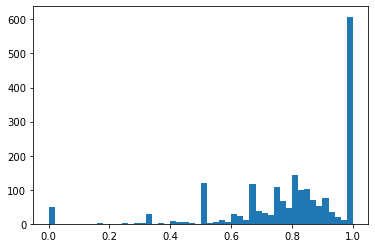

In [320]:
plt.hist(target_accuracy, bins=50)

In [366]:
(features_scaled_train_val, features_scaled_test, 
target_accuracy_train_val, target_accuracy_test,
words_train_val, words_test) =  train_test_split(features, target_accuracy, words, 
                                                                random_state=2, test_size=0.3)

In [367]:
(features_scaled_train, features_scaled_val, 
 target_accuracy_train, target_accuracy_val,
 words_train, words_val) = train_test_split(features_scaled_train_val, 
                                                                target_accuracy_train_val,
                                                                words_train_val,
                                                                random_state=2, test_size=0.1)

In [368]:
# standardize the dataset - https://scikit-learn.org/stable/modules/preprocessing.html
# std in scaler.scale_
# mean in scaler.mean_
scaler = preprocessing.StandardScaler().fit(features_scaled_train)

In [369]:
features_scaled_train = scaler.transform(features_scaled_train)
features_scaled_val = scaler.transform(features_scaled_val)
features_scaled_test = scaler.transform(features_scaled_test)

In [237]:
from sklearn.ensemble import RandomForestRegressor

lr = RandomForestRegressor().fit(features_scaled_train, target_accuracy_train)
pred_accuracy_test = lr.predict(features_scaled_test)
print(f" R^2 score: {lr.score(features_scaled_test, target_accuracy_test)}")
print(f" mse score: {np.sum((pred_accuracy_test - target_accuracy_test)**2)/len(pred_accuracy_test)}")

 R^2 score: -0.12076708220307064
 mse score: 0.04569889101835418


/opt/conda/envs/tf14/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/envs/tf14/lib/python3.7/site-packages/sklearn/utils/fixes.py:223: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/opt/conda/envs/tf14/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

In [370]:
from sklearn.linear_model import LinearRegression


lr = LinearRegression().fit(features_scaled_train, target_accuracy_train)
pred_accuracy_test = lr.predict(features_scaled_test)
print(f" R^2 score: {lr.score(features_scaled_test, target_accuracy_test)}")
print(f" mse score: {np.sum((pred_accuracy_test - target_accuracy_test)**2)/len(pred_accuracy_test)}")
print(f" spearman : {stats.spearmanr(pred_accuracy_test, target_accuracy_test)[0]}")

 R^2 score: -0.003235539902542328
 mse score: 0.04135309252368285
 spearman : -0.029509068865170848


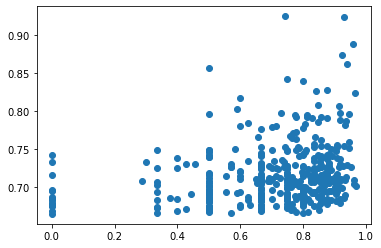

In [269]:
import matplotlib.pyplot as plt
plt.scatter(target_accuracy_test, pred_accuracy_test)

In [145]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [239]:
# train a linear regression model
import torch
import torch.nn.functional as F
from torch.autograd import Variable

class linearRegression(torch.nn.Module):
    def __init__(self):
        super(linearRegression, self).__init__()
        self.fc1 = torch.nn.Linear(6, 30)
        self.fc2 = torch.nn.Linear(30, 1)
        

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.sigmoid(self.fc2(out))
        return out

In [240]:
lr = 0.001

In [241]:
model = linearRegression().to(device)
print(model)

linearRegression(
  (fc1): Linear(in_features=6, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=1, bias=True)
)


In [242]:
if torch.cuda.is_available():
    model.cuda()

In [243]:
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [244]:
# function to save checkpoint
# https://pytorch.org/tutorials/beginner/saving_loading_models.html
#https://towardsdatascience.com/how-to-save-and-load-a-model-in-pytorch-with-a-complete-example-c2920e617dee
checkpoint_path = '/data/sherin/checkpoint_lm/linear_regression_best.pt.tar'


In [245]:
inputs_train = torch.tensor(features_scaled_train).to(device)
targets_train = torch.tensor(target_accuracy_train).to(device)

inputs_val = torch.tensor(features_scaled_val).to(device)
targets_val = torch.tensor(target_accuracy_val).to(device)

inputs_test = torch.tensor(features_scaled_test).to(device)
targets_test = torch.tensor(target_accuracy_test).to(device)

In [246]:
epochs = 1000
epoch_loss_list = []
accuracy_list = []
val_loss_list = []
val_acc_list = []
val_min_loss = np.inf

for epoch in range(epochs):
    epoch_loss = 0.0
    accuracy = 0.0
    model.train()

    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs_train.float())

    # get loss for the predicted output
    loss = criterion(outputs, targets_train.float())
    print(loss)
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()
    
    model.eval()
    
    # get output from the model, given the inputs
    outputs = model(inputs_val.float())

    # get loss for the predicted output
    loss = criterion(outputs, targets_val.float())
        
    epoch_loss = loss.item()
    
    if epoch_loss < val_min_loss:
        print("saving best model")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, checkpoint_path)
        val_min_loss = epoch_loss
    else:
        print("not saving the model")
    
    epoch_loss_list.append(epoch_loss)
 

    print('epoch {}, loss {}'.format(epoch, loss.item()))

/opt/conda/envs/tf14/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/opt/conda/envs/tf14/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([847])) that is different to the input size (torch.Size([847, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/tf14/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([95])) that is different to the input size (torch.Size([95, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0958, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 0, loss 0.09212551265954971
tensor(0.0943, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 1, loss 0.09050619602203369
tensor(0.0929, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 2, loss 0.0889202207326889
tensor(0.0914, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 3, loss 0.08735788613557816
tensor(0.0900, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 4, loss 0.08582020550966263
tensor(0.0886, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 5, loss 0.08432962000370026
tensor(0.0872, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 6, loss 0.08286651968955994
tensor(0.0859, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 7, loss 0.0814373642206192
tensor(0.0846, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 8, loss 0.08003067970275879
ten

saving best model
epoch 100, loss 0.033145442605018616
tensor(0.0422, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 101, loss 0.03305881842970848
tensor(0.0422, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 102, loss 0.03297619894146919
tensor(0.0421, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 103, loss 0.03289565071463585
tensor(0.0420, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 104, loss 0.032815366983413696
tensor(0.0420, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 105, loss 0.03274013474583626
tensor(0.0419, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 106, loss 0.03266942501068115
tensor(0.0419, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 107, loss 0.03259871527552605
tensor(0.0419, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 108, loss 0.03253309056162834
tensor(0.0418, device='cuda:0', grad_fn=

saving best model
epoch 206, loss 0.03070366010069847
tensor(0.0408, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 207, loss 0.030698958784341812
tensor(0.0408, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 208, loss 0.030695253983139992
tensor(0.0408, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 209, loss 0.030690403655171394
tensor(0.0408, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 210, loss 0.030686156824231148
tensor(0.0408, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 211, loss 0.030681882053613663
tensor(0.0408, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 212, loss 0.030677540227770805
tensor(0.0408, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 213, loss 0.030672907829284668
tensor(0.0408, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 214, loss 0.030669452622532845
tensor(0.0408, device='cuda:0', gr

epoch 309, loss 0.030347103253006935
tensor(0.0405, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 310, loss 0.030343791469931602
tensor(0.0405, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 311, loss 0.03034098632633686
tensor(0.0405, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 312, loss 0.03033813089132309
tensor(0.0405, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 313, loss 0.03033493272960186
tensor(0.0405, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 314, loss 0.030331412330269814
tensor(0.0405, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 315, loss 0.030329495668411255
tensor(0.0405, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 316, loss 0.030326133593916893
tensor(0.0405, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 317, loss 0.030322570353746414
tensor(0.0405, device='cuda:0', grad_fn=<MseLossBackwa

tensor(0.0403, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 415, loss 0.030057646334171295
tensor(0.0403, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 416, loss 0.030054772272706032
tensor(0.0403, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 417, loss 0.030053414404392242
tensor(0.0403, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 418, loss 0.03005085326731205
tensor(0.0403, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 419, loss 0.03004857897758484
tensor(0.0403, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 420, loss 0.030046746134757996
tensor(0.0403, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 421, loss 0.03004414215683937
tensor(0.0403, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 422, loss 0.03004075586795807
tensor(0.0403, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 423, loss

tensor(0.0401, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 521, loss 0.029838839545845985
tensor(0.0401, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 522, loss 0.029837412759661674
tensor(0.0401, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 523, loss 0.02983466163277626
tensor(0.0401, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 524, loss 0.029833253473043442
tensor(0.0401, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 525, loss 0.029832005500793457
tensor(0.0401, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 526, loss 0.02983037382364273
tensor(0.0401, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 527, loss 0.02982865460216999
tensor(0.0401, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 528, loss 0.029827434569597244
tensor(0.0401, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 529, los

saving best model
epoch 625, loss 0.029680058360099792
tensor(0.0400, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 626, loss 0.029678918421268463
tensor(0.0400, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 627, loss 0.029677558690309525
tensor(0.0400, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 628, loss 0.029676305130124092
tensor(0.0400, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 629, loss 0.029674163088202477
tensor(0.0400, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 630, loss 0.029673298820853233
tensor(0.0400, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 631, loss 0.029671674594283104
tensor(0.0400, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 632, loss 0.02967073768377304
tensor(0.0400, device='cuda:0', grad_fn=<MseLossBackward>)
not saving the model
epoch 633, loss 0.029670754447579384
tensor(0.0400, device='cuda:0',

epoch 731, loss 0.029571617022156715
tensor(0.0399, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 732, loss 0.02957111783325672
tensor(0.0399, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 733, loss 0.029570555314421654
tensor(0.0399, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 734, loss 0.029569510370492935
tensor(0.0399, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 735, loss 0.02956860512495041
tensor(0.0399, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 736, loss 0.029568161815404892
tensor(0.0399, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 737, loss 0.029566962271928787
tensor(0.0399, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 738, loss 0.02956651896238327
tensor(0.0399, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 739, loss 0.029566051438450813
tensor(0.0399, device='cuda:0', grad_fn=<MseLossBackwa

tensor(0.0399, device='cuda:0', grad_fn=<MseLossBackward>)
not saving the model
epoch 838, loss 0.029503880068659782
tensor(0.0399, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 839, loss 0.02950190007686615
tensor(0.0399, device='cuda:0', grad_fn=<MseLossBackward>)
not saving the model
epoch 840, loss 0.029502008110284805
tensor(0.0399, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 841, loss 0.029501618817448616
tensor(0.0399, device='cuda:0', grad_fn=<MseLossBackward>)
not saving the model
epoch 842, loss 0.029501628130674362
tensor(0.0399, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 843, loss 0.029500072821974754
tensor(0.0399, device='cuda:0', grad_fn=<MseLossBackward>)
not saving the model
epoch 844, loss 0.02950034663081169
tensor(0.0399, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 845, loss 0.029499812051653862
tensor(0.0399, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
e

not saving the model
epoch 949, loss 0.02945651300251484
tensor(0.0398, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 950, loss 0.029456064105033875
tensor(0.0398, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 951, loss 0.029455553740262985
tensor(0.0398, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 952, loss 0.029455499723553658
tensor(0.0398, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 953, loss 0.029455045238137245
tensor(0.0398, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 954, loss 0.02945484034717083
tensor(0.0398, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 955, loss 0.029454492032527924
tensor(0.0398, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 956, loss 0.02945425733923912
tensor(0.0398, device='cuda:0', grad_fn=<MseLossBackward>)
saving best model
epoch 957, loss 0.02945350483059883
tensor(0.0398, device='cuda:0', gr

In [247]:
model = linearRegression().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
PATH = checkpoint_path
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# inferece
model.eval()
outputs = model(inputs_test.float())
loss = criterion(outputs, targets_test.float())
print('The MSE loss is {}'.format(loss))

The MSE loss is 0.04086948186159134


/opt/conda/envs/tf14/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([404])) that is different to the input size (torch.Size([404, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


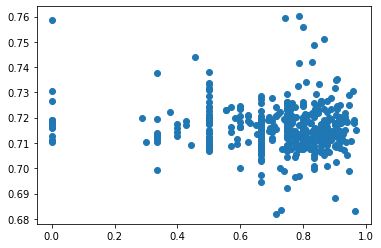

In [248]:
plt.scatter(targets_test.cpu().detach().numpy(), outputs.cpu().detach().numpy())

In [249]:
outputs

tensor([[0.7116],
        [0.7114],
        [0.7202],
        [0.7189],
        [0.7144],
        [0.7140],
        [0.7075],
        [0.7334],
        [0.7150],
        [0.7135],
        [0.7092],
        [0.7133],
        [0.7119],
        [0.7068],
        [0.6989],
        [0.7264],
        [0.7120],
        [0.7277],
        [0.7108],
        [0.7101],
        [0.7126],
        [0.7168],
        [0.7102],
        [0.7170],
        [0.7160],
        [0.7185],
        [0.7202],
        [0.7180],
        [0.7178],
        [0.7090],
        [0.7157],
        [0.7247],
        [0.7120],
        [0.7172],
        [0.7317],
        [0.7076],
        [0.7091],
        [0.7157],
        [0.7157],
        [0.7246],
        [0.7142],
        [0.7267],
        [0.7185],
        [0.7119],
        [0.7249],
        [0.7180],
        [0.7191],
        [0.7218],
        [0.7132],
        [0.7036],
        [0.7147],
        [0.7416],
        [0.7147],
        [0.7169],
        [0.7143],
        [0

In [252]:
from scipy import stats

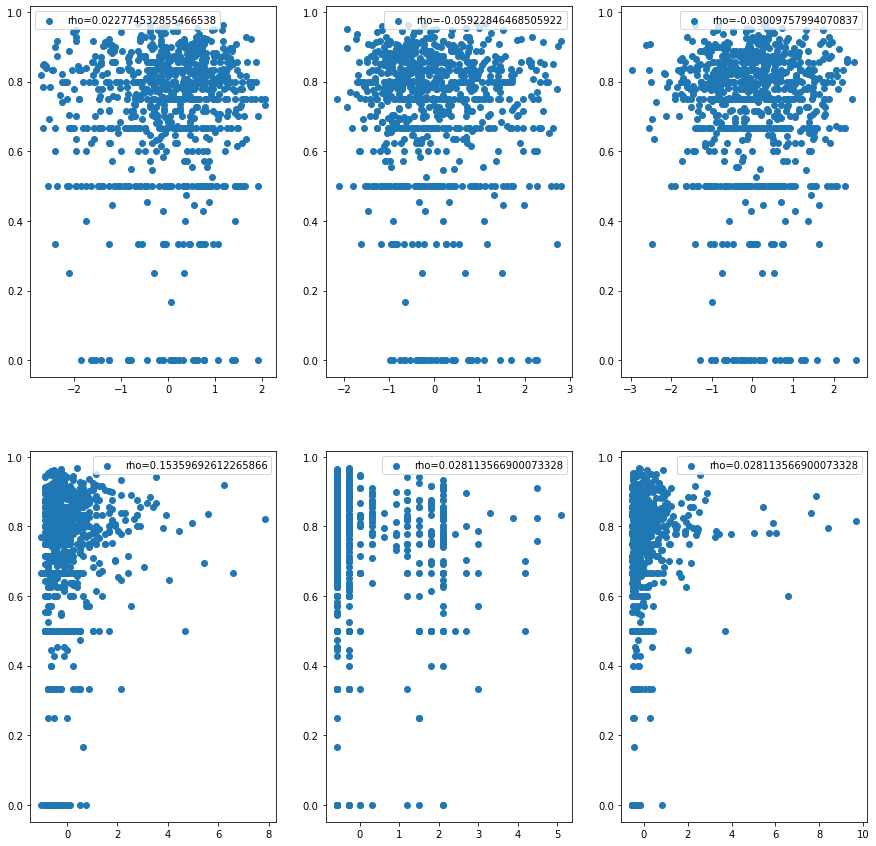

In [255]:
fig, axs = plt.subplots(2,3, figsize=[15,15])
axs[0,0].scatter(features_scaled_train[:,0], target_accuracy_train,
                label=f"rho={stats.spearmanr(features_scaled_train[:,0], target_accuracy_train)[0]}")
axs[0,0].legend()
axs[0,1].scatter(features_scaled_train[:,1], target_accuracy_train,
                label=f"rho={stats.spearmanr(features_scaled_train[:,1], target_accuracy_train)[0]}")
axs[0,1].legend()
axs[0,2].scatter(features_scaled_train[:,2], target_accuracy_train,
                label=f"rho={stats.spearmanr(features_scaled_train[:,2], target_accuracy_train)[0]}")
axs[0,2].legend()
axs[1,0].scatter(features_scaled_train[:,3], target_accuracy_train,
                label=f"rho={stats.spearmanr(features_scaled_train[:,3], target_accuracy_train)[0]}")
axs[1,0].legend()
axs[1,1].scatter(features_scaled_train[:,4], target_accuracy_train,
                label=f"rho={stats.spearmanr(features_scaled_train[:,4], target_accuracy_train)[0]}")
axs[1,1].legend()
axs[1,2].scatter(features_scaled_train[:,5], target_accuracy_train,
                label=f"rho={stats.spearmanr(features_scaled_train[:,4], target_accuracy_train)[0]}")
axs[1,2].legend()

(array([ 48.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   3.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,
         28.,   0.,   0.,   0.,   1.,   0.,   0.,   7.,   0.,   4.,   0.,
          3.,   3.,   0.,   1.,   0.,   0., 120.,   0.,   1.,   0.,   1.,
          5.,   0.,  11.,   4.,   0.,  25.,   3.,  13.,  10.,   5.,   7.,
        116.,   1.,   9.,  30.,   9.,  23.,  14.,  12.,   6., 102.,  23.,
         44.,  34.,  11., 107.,  35.,  26.,  72.,  27.,  74.,  25.,  46.,
         45.,   8.,  53.,  22.,  21.,  13.,  18.,   3.,  10.,   1.,   0.,
        608.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.

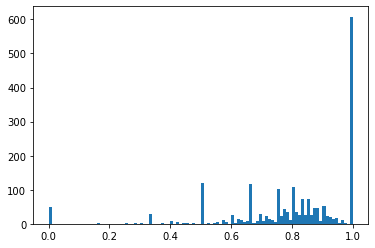

In [223]:
plt.hist(target_accuracy, bins=100)